In [32]:
import numpy as np
import re
import nltk
import networkx as nx
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from transformers import pipeline
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nathanpasca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nathanpasca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/nathanpasca/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [33]:
text = """Mental disorder has been recognized as a significant public health concern and one of the leading causes of disability worldwide, particularly with the loss of productive years of the sufferer's life (1). The Global Burden of Disease report (2019) highlights an increase, from around 80 million to over 125 million, in the worldwide number of Disability-Adjusted Life Years (DALYs) attributable to mental disorders. With this surge, mental disorders have moved into the top 10 significant causes of DALYs worldwide over the last three decades (2). Furthermore, this data does not include substance use disorders (SUDs), which, if included, would increase the estimated burden manifolds. Moreover, if the caregiver-related burden is accounted for, this figure would be much higher. Individual, social, cultural, political, and economic issues are critical mental wellbeing determinants. An increasing burden of mental diseases can, in turn, contribute to deterioration in physical health and poorer social and economic growth of a country (3). Mental health expenditure is roughly 3–4% of their Gross Domestic Products (GDPs) in developed regions of the world; however, the figure is abysmally low in low-and-middle-income countries (LMICs) (4). Untreated mental health and behavioral problems in childhood and adolescents, in particular, have profound long-term social and economic adverse consequences, including increased contact with the criminal justice system, lower employment rate and lesser wages among those employed, and interpersonal difficulties (5–8).

Need for Mental Health (MH) Prevention
Longitudinal studies suggest that individuals with a lower level of positive wellbeing are more likely to acquire mental illness (9). Conversely, factors that promote positive wellbeing and resilience among individuals are critical in preventing mental illnesses and better outcomes among those with mental illness (10, 11). For example, in patients with depressive disorders, higher premorbid resilience is associated with earlier responses (12). On the contrary, patients with bipolar affective- and recurrent depressive disorders who have a lower premorbid quality of life are at higher risk of relapses (13).

Recently there has been an increased emphasis on the need to promote wellbeing and positive mental health in preventing the development of mental disorders, for poor mental health has significant social and economic implications (14–16). Research also suggests that mental health promotion and preventative measures are cost-effective in preventing or reducing mental illness-related morbidity, both at the society and individual level (17).

Although the World Health Organization (WHO) defines health as "a state of complete physical, mental, and social wellbeing and not merely an absence of disease or infirmity," there has been little effort at the global level or stagnation in implementing effective mental health services (18). Moreover, when it comes to the research on mental health (vis-a-viz physical health), promotive and preventive mental health aspects have received less attention vis-a-viz physical health. Instead, greater emphasis has been given to the illness aspect, such as research on psychopathology, mental disorders, and treatment (19, 20). Often, physicians and psychiatrists are unfamiliar with various concepts, approaches, and interventions directed toward mental health promotion and prevention (11, 21).

Prevention and promotion of mental health are essential, notably in reducing the growing magnitude of mental illnesses. However, while health promotion and disease prevention are universally regarded concepts in public health, their strategic application for mental health promotion and prevention are often elusive. Furthermore, given the evidence of substantial links between psychological and physical health, the non-incorporation of preventive mental health services is deplorable and has serious ramifications. Therefore, policymakers and health practitioners must be sensitized about linkages between mental- and physical health to effectively implement various mental health promotive and preventive interventions, including in individuals with chronic physical illnesses (18).

The magnitude of the mental health problems can be gauged by the fact that about 10–20% of young individuals worldwide experience depression (22). As described above, poor mental health during childhood is associated with adverse health (e.g., substance use and abuse), social (e.g., delinquency), academic (e.g., school failure), and economic (high risk of poverty) adverse outcomes in adulthood (23). Childhood and adolescence are critical periods for setting the ground for physical growth and mental wellbeing (22). Therefore, interventions promoting positive psychology empower youth with the life skills and opportunities to reach their full potential and cope with life's challenges. Comprehensive mental health interventions involving families, schools, and communities have resulted in positive physical and psychological health outcomes. However, the data is limited to high-income countries (HICs) (24–28).

In contrast, in low and middle-income countries (LMICs) that bear the greatest brunt of mental health problems, including massive, coupled with a high treatment gap, such interventions remained neglected in public health (29, 30). This issue warrants prompt attention, particularly when global development strategies such as Millennium Development Goals (MDGs) realize the importance of mental health (31). Furthermore, studies have consistently reported that people with socioeconomic disadvantages are at a higher risk of mental illness and associated adverse outcomes; partly, it is attributed to the inequitable distribution of mental health services (32–35)."""


In [34]:
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [35]:
def textrank_summarize(text, num_sentences=5):
    # Tokenize text into sentences
    sentences = sent_tokenize(text)

    # Preprocess each sentence
    clean_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Initialize stop words
    stop_words = set(stopwords.words('english'))

    # Create sentence vectors
    sentence_vectors = []
    for sentence in clean_sentences:
        words = sentence.split()
        words = [word for word in words if word not in stop_words]
        if words:  # Only add non-empty sentences
            sentence_vectors.append(words)
        else:
            sentence_vectors.append(['dummy'])  # Add placeholder for empty sentences

    # Create similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    # Compute sentence similarities
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:  # Skip comparing sentence with itself
                # Get word sets for each sentence
                words_i = set(sentence_vectors[i])
                words_j = set(sentence_vectors[j])

                # Calculate Jaccard similarity (simpler than cosine)
                if len(words_i) > 0 and len(words_j) > 0:
                    intersection = words_i.intersection(words_j)
                    union = words_i.union(words_j)
                    similarity_matrix[i][j] = len(intersection) / len(union)

    # Create graph and apply PageRank
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)

    # Rank sentences by score
    ranked_sentences = sorted(((scores[i], i, s) for i, s in enumerate(sentences)), reverse=True)

    # Get top sentences
    top_sentences = []
    for i in range(min(num_sentences, len(ranked_sentences))):
        top_sentences.append(ranked_sentences[i][2])

    # Sort by original order
    sentence_indices = [sentences.index(sentence) for sentence in top_sentences]
    sorted_top_sentences = [x for _, x in sorted(zip(sentence_indices, top_sentences))]

    return "\n".join(sorted_top_sentences)

In [36]:
def transformer_summarize(text, max_length=150, min_length=50):
    # Initialize the summarization pipeline with a tiny model and batch_size=1
    try:
        summarizer = pipeline("summarization", model="facebook/bart-base", batch_size=1)
    except:
        # Fallback to an even smaller model
        try:
            summarizer = pipeline("summarization", model="t5-small", batch_size=1)
        except:
            # Final fallback to extremely small model
            summarizer = pipeline("summarization", model="sshleifer/distilbart-xsum-12-3", batch_size=1)

    # Use much smaller chunks to prevent memory issues
    max_chunk_length = 512  # Reduced from 1024
    sentences = sent_tokenize(text)
    current_chunk = []
    chunks = []
    current_size = 0

    # Make sure we don't exceed the token limit
    for sentence in sentences:
        words = sentence.split()
        # If a single sentence is too large, break it up (important fix!)
        if len(words) > max_chunk_length:
            # Process very long sentences word by word
            temp_sentence = []
            temp_size = 0
            for word in words:
                if temp_size + 1 > max_chunk_length//2:  # Even more conservative
                    chunks.append(" ".join(temp_sentence))
                    temp_sentence = [word]
                    temp_size = 1
                else:
                    temp_sentence.append(word)
                    temp_size += 1
            if temp_sentence:
                current_chunk.extend(temp_sentence)
                current_size += len(temp_sentence)
        # Normal case: add whole sentences when possible
        elif current_size + len(words) > max_chunk_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_size = len(words)
        else:
            current_chunk.append(sentence)
            current_size += len(words)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    # Summarize each chunk with error handling
    summaries = []
    for i, chunk in enumerate(chunks):
        try:
            # Handle empty or very short chunks
            if len(chunk.split()) < min_length:
                summaries.append(chunk)
                continue

            # Add error handling for each chunk
            result = summarizer(
                chunk,
                max_length=max_length,
                min_length=min(min_length, len(chunk.split())-1),  # Ensure min_length is valid
                do_sample=False,
                truncation=True
            )
            summary = result[0]['summary_text']
            summaries.append(summary)
        except Exception as e:
            print(f"Error summarizing chunk {i}: {str(e)}")
            # If summarization fails, include a portion of the original chunk
            summaries.append(" ".join(chunk.split()[:50]) + "...")

    return " ".join(summaries)

In [37]:
# Get the TextRank summary
print("Generating TextRank summary...")
textrank_summary = textrank_summarize(text, num_sentences=5)
print("\nTextRank Summary:")
print(textrank_summary)
print("\nTextRank Summary Word Count:", len(textrank_summary.split()))

# Get the Transformer summary (uncomment if you have enough memory/resources)
print("\nGenerating Transformer summary...")
try:
    transformer_summary = transformer_summarize(text)
    print("\nTransformer Summary:")
    print(transformer_summary)
    print("\nTransformer Summary Word Count:", len(transformer_summary.split()))
except Exception as e:
    print(f"\nError generating transformer summary: {e}")
    print("This might be due to memory constraints in Google Colab. Try using a GPU runtime or skip this part.")
    transformer_summary = "Error generating summary."

Generating TextRank summary...

TextRank Summary:
An increasing burden of mental diseases can, in turn, contribute to deterioration in physical health and poorer social and economic growth of a country (3).
Need for Mental Health (MH) Prevention
Longitudinal studies suggest that individuals with a lower level of positive wellbeing are more likely to acquire mental illness (9).
Recently there has been an increased emphasis on the need to promote wellbeing and positive mental health in preventing the development of mental disorders, for poor mental health has significant social and economic implications (14–16).
Prevention and promotion of mental health are essential, notably in reducing the growing magnitude of mental illnesses.
Comprehensive mental health interventions involving families, schools, and communities have resulted in positive physical and psychological health outcomes.

TextRank Summary Word Count: 121

Generating Transformer summary...

Error generating transformer summar

In [38]:
print("\nOriginal Text Word Count:", len(text.split()))
original_sentences = sent_tokenize(text)
textrank_sentences = sent_tokenize(textrank_summary)

print("\nComparison Metrics:")
print(f"Original Text: {len(text.split())} words, {len(original_sentences)} sentences")
print(f"TextRank Summary: {len(textrank_summary.split())} words, {len(textrank_sentences)} sentences")
print(f"TextRank Compression Ratio: {len(textrank_summary.split()) / len(text.split()) * 100:.2f}%")

if transformer_summary != "Error generating summary.":
    transformer_sentences = sent_tokenize(transformer_summary)
    print(f"Transformer Summary: {len(transformer_summary.split())} words, {len(transformer_sentences)} sentences")
    print(f"Transformer Compression Ratio: {len(transformer_summary.split()) / len(text.split()) * 100:.2f}%")


Original Text Word Count: 814

Comparison Metrics:
Original Text: 814 words, 32 sentences
TextRank Summary: 121 words, 5 sentences
TextRank Compression Ratio: 14.86%


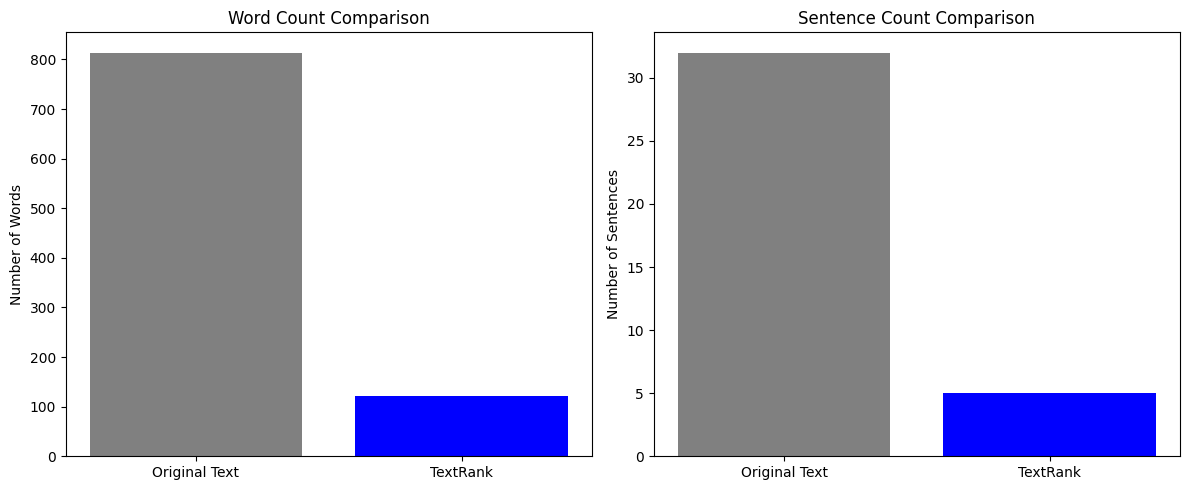

In [39]:
try:
    # Simple visualization
    labels = ['Original Text']
    word_counts = [len(text.split())]
    sentence_counts = [len(original_sentences)]

    # Add TextRank data
    labels.append('TextRank')
    word_counts.append(len(textrank_summary.split()))
    sentence_counts.append(len(textrank_sentences))

    # Add Transformer data if available
    if transformer_summary != "Error generating summary.":
        labels.append('Transformer')
        word_counts.append(len(transformer_summary.split()))
        sentence_counts.append(len(transformer_sentences))

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.bar(labels, word_counts, color=['gray', 'blue', 'green'][:len(labels)])
    ax1.set_title('Word Count Comparison')
    ax1.set_ylabel('Number of Words')

    ax2.bar(labels, sentence_counts, color=['gray', 'blue', 'green'][:len(labels)])
    ax2.set_title('Sentence Count Comparison')
    ax2.set_ylabel('Number of Sentences')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating visualization: {e}")